# Imports

In [2]:
from __future__ import print_function

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy

from skimage.transform import resize
from skimage.io import imsave
from keras.models import Model
from keras.layers import Input, concatenate, Dense, Flatten, Conv3D, MaxPooling3D, Conv3DTranspose, GlobalAveragePooling3D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History

In [4]:
%config Completer.use_jedi = False
data_path = 'data2021/'

In [35]:
train_imgs_path = os.path.join(data_path, 'train/img_train')
train_masks_path = os.path.join(data_path, 'train/mask_train')

## Visualizing for fun

In [36]:
imgPath = os.path.join(train_imgs_path, '01.nii')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(0.0, 1226.9920194894075, (192, 192, 192), numpy.ndarray)

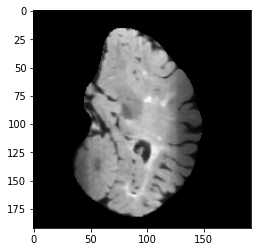

In [37]:
imgSlice = img[120,:,:]
plt.imshow(imgSlice, cmap='gray') 
plt.show()

In [38]:
maskPath = os.path.join(train_masks_path, '01.nii')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 0.9999999997671694, (192, 192, 192), numpy.ndarray)

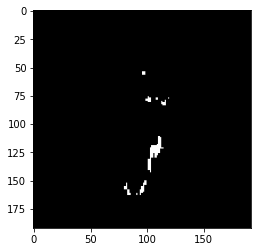

In [39]:
maskSlice = mask[120,:,:]
plt.imshow(maskSlice, cmap='gray')
plt.show()

## Functions to normalize and load nifti files

In [61]:
def normalize(input_img):
    img_normalized = (input_img - np.min(input_img))/(np.max(input_img) - np.min(input_img))
    img_normalized = img_normalized.astype("float32")
    return img_normalized

def load_volume(path, norm=True):
    volume = nib.load(path).get_fdata()
    volume = scipy.ndimage.zoom(input=volume,zoom=0.5)
    if (norm):
        volume = normalize(volume)
    return volume

## Saving paths to files

In [64]:
img_train_paths = [os.path.join(os.getcwd(), "data2021/train/img_train", x)
                     for x in os.listdir("data2021/train/img_train")]
img_train_paths.sort()

mask_train_paths = [os.path.join(os.getcwd(), "data2021/train/mask_train", x)
                     for x in os.listdir("data2021/train/mask_train")]
mask_train_paths.sort()

img_test_paths = [os.path.join(os.getcwd(), "data2021/test", x)
                     for x in os.listdir("data2021/test")]
img_test_paths.sort()


## Loading nifti files to numpy array

In [65]:
imgs_train = np.array([load_volume(path, True) for path in img_train_paths])
masks_train = np.array([load_volume(path, True) for path in mask_train_paths])

imgs_test = np.array([load_volume(path, True) for path in img_test_paths])

In [66]:
imgs_train.shape, masks_train.shape, imgs_test.shape

((14, 96, 96, 96), (14, 96, 96, 96), (5, 96, 96, 96))

In [67]:
print(np.average(imgs_train))
print(np.average(masks_train))
print(np.average(imgs_test))

0.13693215
0.19765812
0.15587002


### ??? Since the data is stored in rank-3 tensors of shape (samples, height, width, depth), we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on the data. The new shape is thus (samples, height, width, depth, 1). ???

In [69]:
imgs_train = tf.expand_dims(imgs_train, axis=4)
masks_train = tf.expand_dims(masks_train, axis=4)
imgs_test = tf.expand_dims(imgs_test, axis=4)

imgs_train.shape, masks_train.shape, imgs_test.shape

(TensorShape([14, 96, 96, 96, 1]),
 TensorShape([14, 96, 96, 96, 1]),
 TensorShape([5, 96, 96, 96, 1]))

In [70]:
type(imgs_train)

tensorflow.python.framework.ops.EagerTensor

## Change from EagerTensor to numpy array

In [71]:
imgs_train = np.array(imgs_train)
masks_train = np.array(masks_train)
imgs_test = np.array(imgs_test)

In [72]:
type(imgs_train)

numpy.ndarray

In [73]:
print(np.average(imgs_train))
print(np.average(masks_train))
print(np.average(imgs_test))

0.13693215
0.19765812
0.15587002


## Saving numpy arrays with loaded images

In [74]:
np.save('imgs_train2021.npy',imgs_train)
np.save('masks_train2021.npy', masks_train)
np.save('imgs_test2021.npy', imgs_test)

## Defining loss functions

In [16]:
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Creating models

In [17]:
def get_model(img_rows=96, img_cols=96, img_depth=96):
    
    inputs = Input((img_rows, img_cols, img_depth, 1))
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(
        2, 2, 2), padding='same')(conv5), conv4], axis=-1)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(
        2, 2, 2), padding='same')(conv6), conv3], axis=-1)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(
        2, 2, 2), padding='same')(conv7), conv2], axis=-1)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(
        2, 2, 2), padding='same')(conv8), conv1], axis=-1)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5),
                  loss=dice_coef_loss, metrics=[dice_coef, 'accuracy'])

    return model

In [17]:
def get_model_simple(img_rows=96, img_cols=96, img_depth=96):
    """Build a 3D convolutional neural network model."""

    inputs = Input((img_rows, img_cols, img_depth, 1))

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling3D()(x)
    x = Dense(units=512, activation="relu")(x)
    x = Dropout(0.3)(x)

    outputs = Conv3D(1, (1, 1, 1), activation='sigmoid')(x)
#     outputs = Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = Model(inputs, outputs, name="3dcnn")
    return model


In [7]:
imgs_train = np.load('imgs_train2021.npy')
masks_train = np.load('masks_train2021.npy')
imgs_test = np.load('imgs_test2021.npy')

In [12]:
imgs_train.shape, masks_train.shape, imgs_test.shape

((14, 96, 96, 96, 1), (14, 96, 96, 96, 1), (5, 96, 96, 96, 1))